In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from collections import defaultdict
from crystallus import __version__, CrystalGenerator, WyckoffCfgGenerator
from crystallus.utils import WyckoffPositionConverter, build_structure, get_equivalent_coords, structure_dissimilarity 
from pymatgen import Structure
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

In [2]:
__version__

'0.3.0.dev'

## Test case: `Ag32Ge4S24`.

* Spacegroup 33
* Wyckoff positions:
    (x,y,z) (-x,-y,z+1/2) (x+1/2,-y+1/2,z) (-x+1/2,y+1/2,z+1/2)
* Ground truth:
    {Ag: 4a \* 8, Ge: 4a, S: 4a \* 5}

In [2]:
wg = WyckoffCfgGenerator(Ag=32, Ge=4, S=24)
wg

WyckoffCfgGenerator(            
    max_recurrent=1000,            
    n_jobs=-1            
    priority=None            
    composition={'Ag': 32, 'Ge': 4, 'S': 24}            
)

In [3]:
cfgs = wg.gen_many(1000, 33)
cfgs

[{'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
  'Ge': ['a'],
  'S': ['a', 'a', 'a', 'a', 'a', 'a']}]

Please note that space group 33 only has one Wyckoff position set.

In [4]:
cg = CrystalGenerator(
    spacegroup_num=33,
    estimated_volume=1168.454590,
    estimated_variance=15,
    verbose=False,
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    estimated_volume=1168.45459,            
    estimated_variance=15,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    empirical_coords=None,            
    empirical_coords_variance=0.01,            
    n_jobs=-1            
)

### Test the most strict case

In [5]:
%%time

expect_size = 100_000_000
results = []
ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=0)
len(ret)

CPU times: user 9h 3min 5s, sys: 2min 3s, total: 9h 5min 9s
Wall time: 20min 12s


0

### Calculate the `distance_scale_factor` dependency

In [6]:
%%time

expect_size = 500_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 43min 36s, sys: 9.24 s, total: 43min 45s
Wall time: 1min 41s


In [7]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
results.to_pickle('results.pd.xz')
results.head(3)

,scale,proportion,S-S,S-Ge,S-Ag,Ge-Ge,Ge-Ag,Ag-Ag
0,0.20,0.000000,1.6320,1.760,1.9360,1.8880,2.0640,2.240
1,0.22,0.000002,1.5912,1.716,1.8876,1.8408,2.0124,2.184
2,0.24,0.000000,1.5504,1.672,1.8392,1.7936,1.9608,2.128


(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

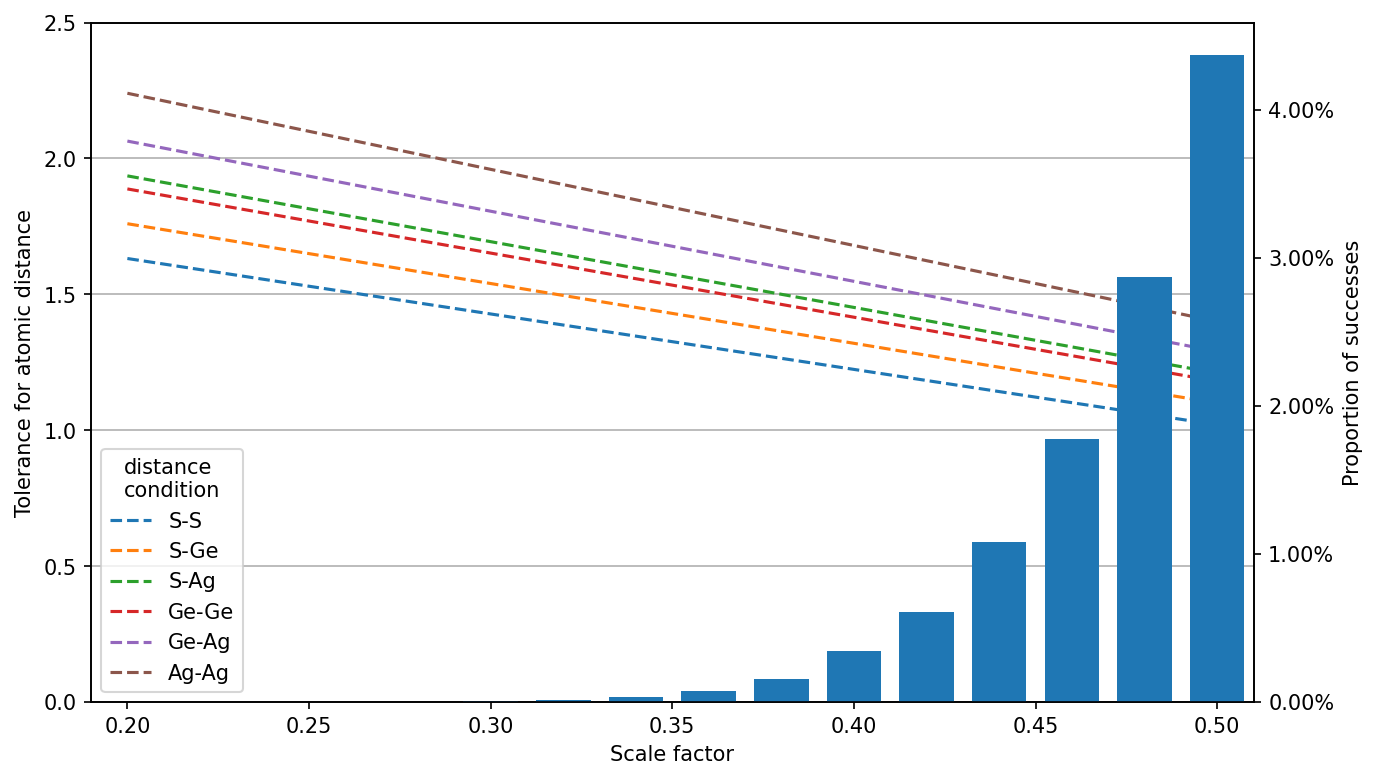

In [8]:
from matplotlib.ticker import FormatStrFormatter, PercentFormatter

f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

From the result of `distance_scale_factor` dependency. Set the `distance_scale_factor` to `0.45` seems to be a good choice.

### Generation using empirical atomic coordinates

In [3]:
structure = Structure.from_file('cifs/Ag8GeS6_mp-9770_primitive.cif')
spg_num = structure.get_space_group_info()[1]
structure

Structure Summary
Lattice
    abc : 7.626161 10.743155 15.313245
 angles : 90.0 90.0 90.0
 volume : 1254.599304070796
      A : 7.626161 0.0 4.669676829216189e-16
      B : -6.578285191746942e-16 10.743155 6.578285191746942e-16
      C : 0.0 0.0 15.313245
PeriodicSite: Ag (7.5876, 1.0208, 11.8156) [0.9949, 0.0950, 0.7716]
PeriodicSite: Ag (6.6626, 4.3578, 11.3221) [0.8737, 0.4056, 0.7394]
PeriodicSite: Ag (0.9635, 9.7294, 3.9911) [0.1263, 0.9056, 0.2606]
PeriodicSite: Ag (4.7766, 4.3578, 3.6655) [0.6263, 0.4056, 0.2394]
PeriodicSite: Ag (3.9392, 1.2013, 7.4041) [0.5165, 0.1118, 0.4835]
PeriodicSite: Ag (3.6869, 6.5729, 7.9091) [0.4835, 0.6118, 0.5165]
PeriodicSite: Ag (7.5000, 1.2013, 15.0607) [0.9835, 0.1118, 0.9835]
PeriodicSite: Ag (0.1261, 6.5729, 0.2525) [0.0165, 0.6118, 0.0165]
PeriodicSite: Ag (6.7044, 2.0538, 3.5062) [0.8791, 0.1912, 0.2290]
PeriodicSite: Ag (0.9218, 7.4253, 11.8070) [0.1209, 0.6912, 0.7710]
PeriodicSite: Ag (4.7349, 2.0538, 11.1629) [0.6209, 0.1912, 0.7290]
Pe

get equivalent coordinates for each site

In [4]:
t = get_equivalent_coords(structure)
t

,element,multiplicity,wyckoff_letter,coordinate
0,Ag,4,a,"[0.994945, 0.095017, 0.771593]"
1,Ag,4,a,"[0.873654, 0.405638, 0.739368]"
2,Ag,4,a,"[0.51654, 0.111819, 0.48351]"
3,Ag,4,a,"[0.87913, 0.191169, 0.228967]"
4,Ag,4,a,"[0.61087, 0.190429, 0.087637]"
5,Ag,4,a,"[0.566539, 0.522052, 0.066411]"
6,Ag,4,a,"[0.733839, 0.335581, 0.436881]"
7,Ag,4,a,"[0.770548, 0.869876, 0.370507]"
8,Ge,4,a,"[0.733802, 0.850394, 0.12383]"
9,S,4,a,"[0.765449, 0.105633, 0.376252]"


convert to Wyckoff position format

In [5]:
wyckoff_pos = WyckoffPositionConverter(spg_num)
xyzs = [(a, wyckoff_pos(a, b)) for _, (a, b) in t[['wyckoff_letter', 'coordinate']].iterrows()]
xyzs

[('a', [0.994945, 0.095017, 0.771593]),
 ('a', [0.873654, 0.405638, 0.739368]),
 ('a', [0.51654, 0.111819, 0.48351]),
 ('a', [0.87913, 0.191169, 0.228967]),
 ('a', [0.61087, 0.190429, 0.087637]),
 ('a', [0.566539, 0.522052, 0.066411]),
 ('a', [0.733839, 0.335581, 0.436881]),
 ('a', [0.770548, 0.869876, 0.370507]),
 ('a', [0.733802, 0.850394, 0.12383]),
 ('a', [0.765449, 0.105633, 0.376252]),
 ('a', [0.812687, 0.367857, 0.112236]),
 ('a', [0.725622, 0.727762, 0.241888]),
 ('a', [0.973621, 0.97378, 0.126849]),
 ('a', [0.769252, 0.7278, 0.505203]),
 ('a', [0.996893, 0.475094, 0.379234])]

In [6]:
cg = CrystalGenerator(
    spacegroup_num=spg_num,
    estimated_volume=1254.599172,
    estimated_variance=10,
    empirical_coords=xyzs,
    empirical_coords_variance=0
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    estimated_volume=1254.599172,            
    estimated_variance=10,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    empirical_coords=...,            
    empirical_coords_variance=0,            
    n_jobs=-1            
)

In [7]:
ss = cg.gen_one(Ag=['a'] *8, Ge=['a'], S=['a'] * 6, check_distance=False)
ss = build_structure(ss)
ss['structure']

Structure Summary
Lattice
    abc : 9.67630815256813 9.161667291538638 14.302554201378245
 angles : 90.0 90.0 90.0
 volume : 1267.9373902329446
      A : 9.67630815256813 0.0 5.925029903302999e-16
      B : -5.609903261717897e-16 9.161667291538638 5.609903261717897e-16
      C : 0.0 0.0 14.302554201378245
PeriodicSite: Ag (9.6462, 4.3527, 5.4240) [0.9969, 0.4751, 0.3792]
PeriodicSite: Ag (0.0301, 4.8090, 12.5753) [0.0031, 0.5249, 0.8792]
PeriodicSite: Ag (4.8081, 0.2282, 5.4240) [0.4969, 0.0249, 0.3792]
PeriodicSite: Ag (4.8682, 8.9335, 12.5753) [0.5031, 0.9751, 0.8792]
PeriodicSite: Ag (5.4820, 4.7829, 0.9498) [0.5665, 0.5221, 0.0664]
PeriodicSite: Ag (4.1943, 4.3788, 8.1011) [0.4335, 0.4779, 0.5664]
PeriodicSite: Ag (0.6439, 8.9596, 0.9498) [0.0665, 0.9779, 0.0664]
PeriodicSite: Ag (9.0325, 0.2020, 8.1011) [0.9335, 0.0221, 0.5664]
PeriodicSite: Ag (4.9982, 1.0244, 6.9154) [0.5165, 0.1118, 0.4835]
PeriodicSite: Ag (4.6781, 8.1372, 14.0667) [0.4835, 0.8882, 0.9835]
PeriodicSite: Ag (0.

In [10]:
ss['structure'].to('cif', filename='test.cif', symprec=0.01)

In [8]:
t_ = get_equivalent_coords(ss['structure'])

In [9]:
sorted(np.array(t['coordinate'].tolist())[:, 0]) == sorted(np.array(t_['coordinate'].tolist())[:, 0])

True